<a href="https://colab.research.google.com/github/Indukurivigneshvarma/Deep_Learning/blob/main/Time_Series/SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
import pandas as pd

url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
df = pd.read_csv(url)

df.columns = df.columns.str.strip().str.capitalize()

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.asfreq('D')

print(df.head())
print("\nRows:", len(df))
print("Date Range:", df.index.min(), "→", df.index.max())

            Temp
Date            
1981-01-01  20.7
1981-01-02  17.9
1981-01-03  18.8
1981-01-04  14.6
1981-01-05  15.8

Rows: 3652
Date Range: 1981-01-01 00:00:00 → 1990-12-31 00:00:00


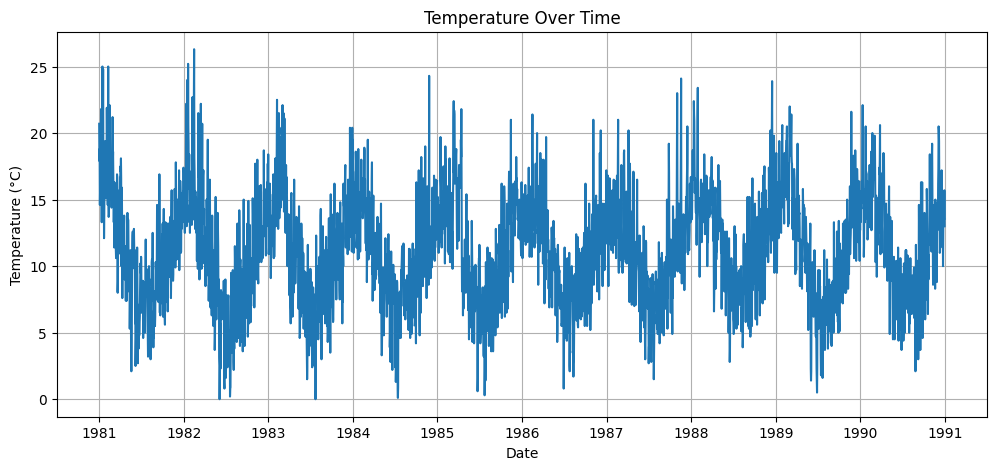

In [4]:
plt.figure(figsize=(12,5))
plt.plot(df['Temp'], color='tab:blue')
plt.title("Temperature Over Time")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.show()

In [5]:
print("Missing values before fix:", df['Temp'].isna().sum())

df['Temp'] = df['Temp'].fillna(method='ffill')

print("Missing values after fix:", df['Temp'].isna().sum())

Missing values before fix: 2
Missing values after fix: 0


/tmp/ipython-input-832157111.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Temp'] = df['Temp'].fillna(method='ffill')


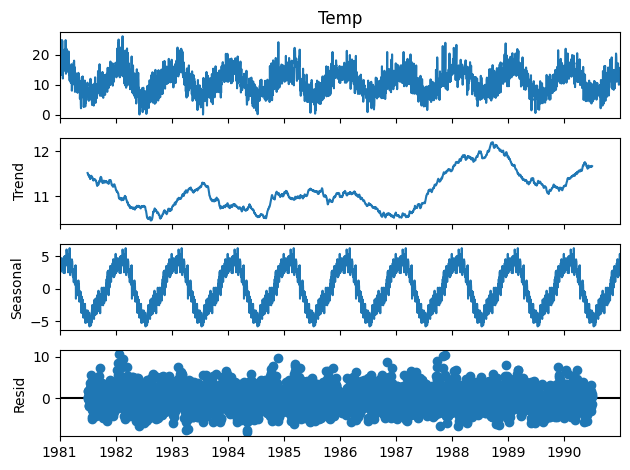

In [6]:
decomposition = seasonal_decompose(df['Temp'], model='additive', period=365)
decomposition.plot()
plt.show()

In [7]:
def adf_test(series):
    result = adfuller(series.dropna(), autolag='AIC')
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] <= 0.05:
        print("✅ Series is stationary")
    else:
        print("❌ Series is non-stationary")
    return result[1]

p_value = adf_test(df['Temp'])

ADF Statistic: -4.440933664385129
p-value: 0.0002510472415292789
✅ Series is stationary


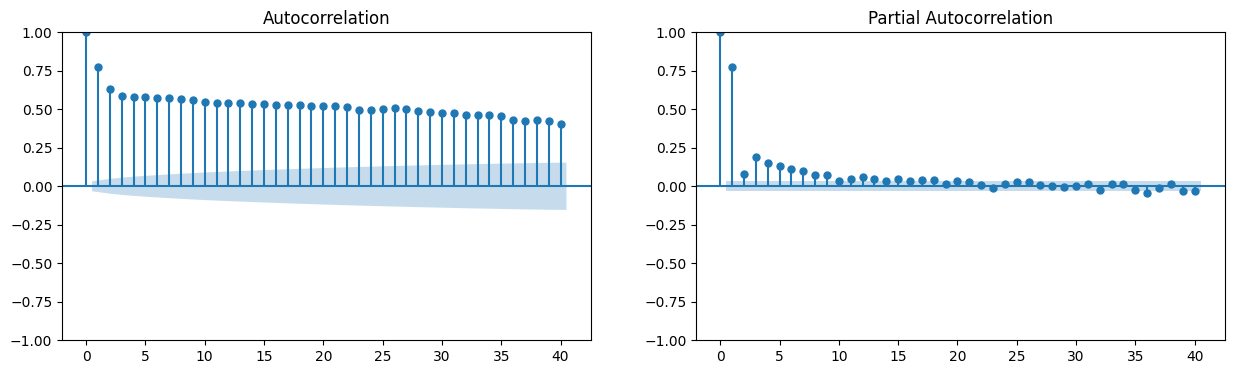

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15,4))
plot_acf(df['Temp'].dropna(), lags=40, ax=ax[0])
plot_pacf(df['Temp'].dropna(), lags=40, ax=ax[1])
plt.show()

In [9]:
model = SARIMAX(df['Temp'],
                order=(1, 0, 1),
                seasonal_order=(1, 1, 1, 30),
                enforce_stationarity=False,
                enforce_invertibility=False)

result = model.fit(disp=False)
print(result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               Temp   No. Observations:                 3652
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 30)   Log Likelihood               -8522.807
Date:                            Wed, 05 Nov 2025   AIC                          17055.614
Time:                                    11:56:01   BIC                          17086.544
Sample:                                01-01-1981   HQIC                         17066.638
                                     - 12-31-1990                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8667      0.011     81.887      0.000       0.846       0.887
ma.L1         -0.2435      0.019   

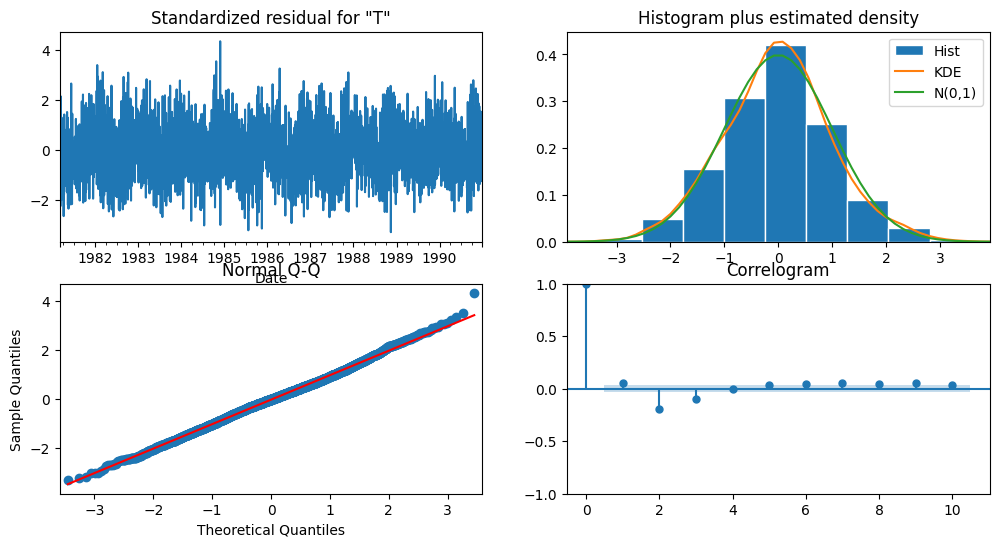

In [10]:
result.plot_diagnostics(figsize=(12,6))
plt.show()

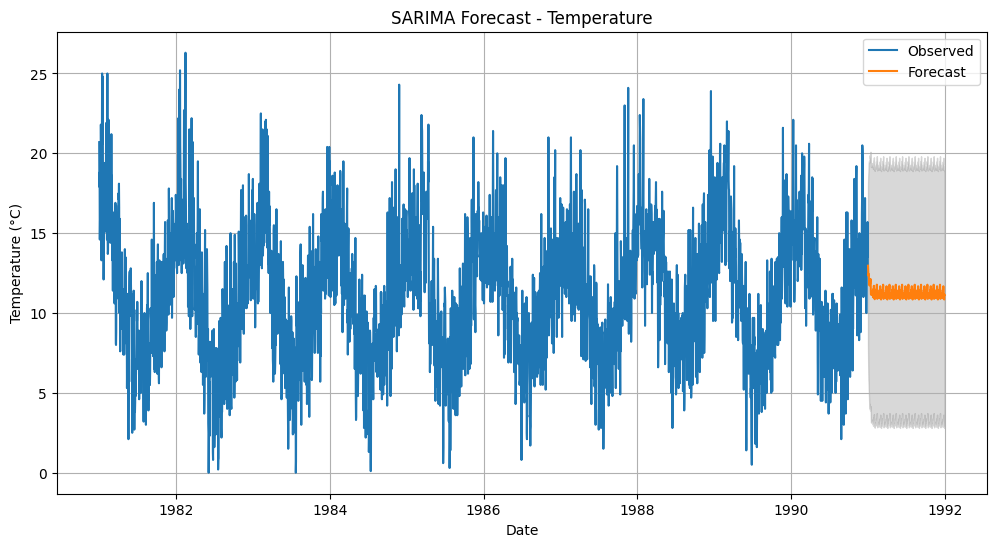

In [11]:
forecast_steps = 365
forecast = result.get_forecast(steps=forecast_steps)
forecast_ci = forecast.conf_int()

plt.figure(figsize=(12,6))
plt.plot(df.index, df['Temp'], label='Observed')
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, label='Forecast', color='tab:orange')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='gray', alpha=0.3)
plt.title("SARIMA Forecast - Temperature")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.show()